In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import numpy as np
import codecs
import argparse
import math
from scipy.special import comb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import scipy.integrate as integrate
from scipy.integrate import quad
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import floor, log10

parser = argparse.ArgumentParser(description='Plotting data.')
parser.add_argument('--dataset', type=str, help='dataset', default='vool_stats.csv')
parser.add_argument('--inpath', type=str, help='where the dataset is lcoated', default='../../../resources/')
parser.add_argument('--outpath', type=str, help='where to put the charts', default='../../../output/')
args, unknown = parser.parse_known_args()

# ==============================================================================
# Chart variables
# ==============================================================================
titlesize = 16
subtitlesize = 14
labelsize = 14
axessize = 12
legendsize = 11
markersize = 5

# http://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('grayscale')
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
font = font_manager.FontProperties(family='serif', size=legendsize)

# Markers - https://matplotlib.org/api/markers_api.html
markers = ["v", "^", "<", ">", "8", "s", "p", "P", "*", "+", "X", "D", "o", "s"]
linestyle_tuple = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot')]  # Same as '-.'

linestyle_tuple2 = [
#      ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

#      ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

#      ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
#      ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
greyscale = ['silver', 'grey', 'lightgrey', 'black']

# Lines - https://matplotlib.org/gallery/lines_bars_and_markers/line_styles_reference.html

# =============================================================================
# Location String	Location Code
# 'best'	0
# 'upper right'	1
# 'upper left'	2
# 'lower left'	3
# 'lower right'	4
# 'right'	5
# 'center left'	6
# 'center right'	7
# 'lower center'	8
# 'upper center'	9
# 'center'	10
# =============================================================================

# =============================================================================
# These are the "Tableau 20" colors as RGB.
# http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
# =============================================================================
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# ==============================================================================
path = args.inpath
outpath = args.outpath
filename = args.dataset

# datasets = ["Foodmart", "SSB"]  # ["dataset_patrick", "dataset_patrick_ssb"]
# data = pd.DataFrame()
# with codecs.open(path + filename, 'r', encoding='utf-8') as f:
#     data = pd.read_csv(f, sep=';')
#     # data.infer_objects()
# data["dataset"] = data["dataset"].apply(lambda x: "SSB" if "ssb" in x else "Foodmart")
# data["synMeta"] = data["synMeta"] + 1
# msize, m, ls, l, c = marker(filename)

# You typically want your plot to be ~1.33x wider than tall. This plot is a rare
# exception because of the number of lines being plotted on it.
# Common sizes: (10, 7.5) and (12, 9)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
figsize11 = (4, 3)
figsize12 = (8, 3)
figsize13 = (12, 3)
figsize22 = (8, 6)
col_width = 0.15

def default_plotsetup(ax):
    ax.grid(color="lightgray", linestyle='-', linewidth=0.3)
    ax.set_axisbelow(True)

In [2]:
df = pd.read_csv(path + filename)

df.describe()
min_python_time = df[(df["module"].isin(["Correlation", "SlicingVariance", "DomainVariance", "AggregationVariance"])) & (df["card"] == 100)]["time"].min() + 1
df["module"].unique()
df["time"] = df.apply(lambda x: x["time"] - (min_python_time if x["module"] not in ["Top-K", "Bottom-K", "Statistics", "Preamble", "Mckp", "mkcp", "Assess"] else 0), axis=1)
df["time"] = df["time"] + 1
df["time"] = df["time"] / 1000

def round_power_of_10(n):
    import math
    exp = math.log(n, 10)
    exp = round(exp)
    return 10 ** exp

d = {
    "assess": "Assess",
    "skyline": "Skyline",
    "clustering": "Clustering",
    "cardvariance": "CardVariance",
    "sadincrease": "SliceVariance",
    "outlierdetection": "OutlierDetection",
    "preamble": "Preamble",
    "correlation": "Correlation",
    "intravariance": "AggregationVariance"
}
df["module"] = df["module"].replace(d)
df["time"] = df["time"].apply(lambda x: x) #round_power_of_10(x)
# df = df[df["seed"] == df["seed"].max()]
df = df[df["card"] == df["limit"]]
df = df[df["module"] != "Mckp"]
df = df[df["module"] != "UniformAggregationVariance"]
df[df["time"] < 0]

,budget,card,cube,length,limit,module,npatterns,queryid,seed,selected,selected_cost,selected_int,sessionid,time,uid


In [3]:
def init_X(budget=None):
    def v(X):
        X = X.sort_values(["time"])
        X["c"] = 1
        # X["cum_time"] = X["time"].cumsum().apply(lambda x: x)
        X["cum_c"] = X["c"].cumsum()
        X["cum_c"] = X.apply(lambda x: x ["cum_c"] / X["cum_c"].max(), axis=1)
        return X
    if budget is None:
        X = df.copy(deep=True)
    else:
        X = df[df["budget"] == budget]
    X = X[X["module"] != "mkcp"].groupby(["uid", "card"]).apply(lambda x: v(x)).reset_index(drop=True)[["uid", "card", "time", "cum_c", "module", "length"]]
    X["id"] = X.apply(lambda x: str(x["uid"]) + "-" + str(x["card"]), axis=1)
    return X

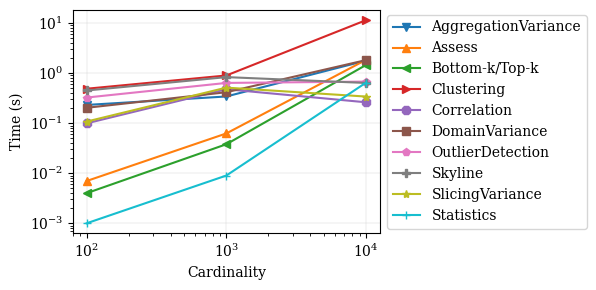

In [4]:
fig, axs = plt.subplots(1, 1, figsize=figsize11)

i = 0
X = init_X(125)
X["time"] = X.apply(lambda x: x["time"], axis=1)
X = X[X["module"] != "Preamble"]
X = X[X["module"] != "Bottom-K"]
X["module"] = X["module"].replace("Top-K", "Bottom-k/Top-k")

msize = 10
for key, group in X.groupby(["module"]):
    ax = axs # axs[0]
    x = group.groupby(["card"])
    x = [x for x in x.groups.keys()]
    y = group.groupby(["card"])["time"].median()
    y = y.tolist()
    ax.plot(x, y, label=key, marker=markers[i]) # , markersize=msize, linestyle=linestyle_tuple[i % len(linestyle_tuple)][1]
    msize -= 0.5
    i += 1
    default_plotsetup(ax)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
    ax.set_xticks([100, 1000, 10000])
    ax.set_xlabel("Cardinality")
    ax.set_ylabel("Time (s)")
fig.tight_layout()
fig.savefig(outpath + "scalability.svg", bbox_inches = 'tight')
fig.savefig(outpath + "scalability.pdf", bbox_inches = 'tight')
fig

14.5


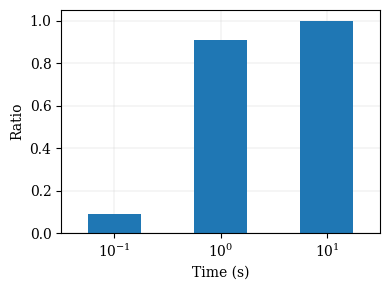

In [5]:
# ax = axs[1]
fig, axs = plt.subplots(1, 1, figsize=figsize11)
ax = axs

X = init_X(125)
X = X[X["card"] == 10000]

print(X[X["module"] == "Preamble"]["length"].mean())

X = X[X["module"] != "Preamble"]
X = X.groupby(["module"]).mean().reset_index()
X["time"] = X["time"].apply(lambda x: round_power_of_10(x))
# X["time"] = X["time"].apply(lambda x: x)
X = X.groupby(["time"])["module"].count().cumsum()
X = X / X.max()
X.plot(kind="bar",ax=ax) #  
ax.set_xticklabels(["$10^{" + str(round(math.log(x, 10))) + "}$" for x in X.keys()], rotation=0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Ratio")
default_plotsetup(ax)
fig.tight_layout()
fig.savefig(outpath + "ratio.svg")
fig.savefig(outpath + "ratio.pdf")
fig

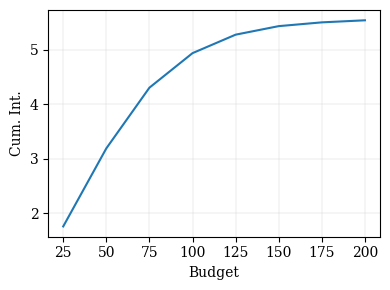

In [6]:
# ax = axs[1]
fig, axs = plt.subplots(1, 1, figsize=figsize11)
ax = axs

X = df.copy(deep=True)
X = X[X["card"] == 100]
X = X[X["selected"]]
X = X[X["module"] != "Preamble"]
X = X[["queryid", "budget", "selected_cost", "selected_int"]]
Y = X.groupby(["queryid", "budget"]).sum().reset_index().groupby(["budget"])["selected_int"].mean()
Y.plot(ax=ax)

ax.set_xticks(X["budget"].unique(), rotation=0)
ax.set_xticklabels(X["budget"].unique(), rotation=0)
ax.set_xlabel("Budget")
ax.set_ylabel("Cum. Int.")
default_plotsetup(ax)
fig.tight_layout()
fig.savefig(outpath + "budget.svg")
fig.savefig(outpath + "budget.pdf")
fig

In [7]:
from yellowbrick.utils.kneed import KneeLocator
kn = KneeLocator(Y.index.to_numpy(), Y.to_numpy(), curve_nature="concave", curve_direction="increasing")
kn.knee

100

In [8]:
df = pd.read_csv(path + "formResponses.csv")
for c in df.columns:
    df[c] = df[c].replace(" \(Molto alto\)", "", regex=True).replace(" \(Very high\)", "", regex=True).replace(" \(Molto basso\)", "", regex=True).replace(" \(Very low\)", "", regex=True)
df

,Timestamp,How familiar are you with business intelligence and datawarehousing?,Have you already worked with BI tools such as Tableau?,How familiar are you with the English language?,D1.1 Which aspects do you find interesting about the query result?,How well does the text produced by VOOL describe the query result?,How interesting is the description proposed by the single pattern? [Grouped by PRODUCT_DEPARTMENT the average QUANTITY is 13399.],"How interesting is the description proposed by the single pattern? [Facts can be grouped into 3 clusters, the largest has 11 facts and 3606 as average QUANTITY, the second has 6 facts and 16375 as average QUANTITY, the third has 5 facts and 31372 as average QUANTITY.]",How interesting is the description proposed by the single pattern? [The fact with anomalous QUANTITY is (Produce) with QUANTITY 37787.],D1.3 How much did the description of VOOL highlight aspects that you think are important in the result?,...,D2.3 How much did the description of VOOL highlight aspects that you think are important in the result?.1,D3.1 Which aspects do you find interesting about the query result?.1,How well does the text produced by VOOL describe the query result?.5,"How interesting is the description proposed by the single pattern? [Grouped by PRODUCT_CATEGORY the average REVENUE is 13183, the average COST is 5636.]",How interesting is the description proposed by the single pattern? [COST and REVENUE show strong correlation.],"How interesting is the description proposed by the single pattern? [The facts whose REVENUE and COST are both higher than those of all other facts are (Vegetables), (Snack Foods), and (Beer and Wine).]","How interesting is the description proposed by the single pattern? [Facts can be grouped into 2 clusters, the largest has 41 facts and 9138 as average REVENUE, 3647 as average COST, the second has 4 facts and 54647 as average REVENUE, 26021 as average COST.]",D3.3 How much did the description of VOOL highlight aspects that you think are important in the result?.1,"Provide additional comments on VOOL. (e.g., what did you like? what would you improve?)",Evaluate your user experience with VOOL
0,2/18/2022 9:04:26,5,Sì,5,"Molta differenza tra i valori, probabilmente r...",4,5,4,5,5,...,5,I due valori sono linearmente correlati,5,4,5,5,3,5,In alcuni casi evidenzia aspetti che sono diff...,4
1,2/22/2022 9:47:14,5,No,5,There is a high variance in the quantities sol...,4,3,3,5,3,...,3,"There is a linear relationship, except for B&W...",3,4,5,5,1,3,Risposte molto ripetitive. A volte l'ordine de...,4
2,2/22/2022 14:58:00,4,Sì,5,Ci sono 3 (o 5) prodotti che hanno venduto mol...,4,4,5,4,4,...,4,"C'è una forte correlazione e un unico, forte o...",4,4,5,5,3,4,La descrizione di alcuni pattern dovrebbe esse...,5
3,2/22/2022 17:34:57,3,Sì,4,"Esistono reparti che vendono moltissimo, altri...",4,2,5,3,5,...,4,andamento lineare tranne outlier (quali in fav...,4,2,5,5,3,4,"Bello che clusterizza, che fa vedere gli outli...",5
4,3/25/2022 13:37:09,3,Sì,4,Vedere quali sono i prodotti più venduti (prod...,5,3,5,5,5,...,5,Esistono categorie molto redditizie ma anche m...,4,3,4,4,3,3,.,5
5,3/25/2022 13:55:40,2,Sì,5,"Alcoholic, Produce e Snack Foods sono le categ...",1,4,1,5,1,...,4,"Latticini, carne e frutta rendono elevati guad...",2,1,4,5,1,1,Vool è molto preciso ma non fornisce sempre le...,3
6,3/30/2022 11:10:46,3,Sì,4,Il dipartimento più comune è quello chiamato g...,4,2,4,5,2,...,4,Buona parte delle categorie segue un andamento...,4,2,5,5,2,4,Le deduzioni sulle anomalie mi sono sembrate l...,4
7,3/30/2022 12:34:31,3,Sì,5,Il prodotto più venduto è Produce con più di 3...,5,4,4,4,3,...,5,capire quali categorie fanno guadagnare di più...,4,3,4,5,2,3,a volte la descrizione di vool dice cose che s...,4
8,3/31/2022 13:16:59,1,No,4,I prodotti più venduti sono quelli inerenti al...,3,3,1,5,3,...,4,Il rapporto tra costo e guadagno di ciascuna c...,4,3,5,5,1,4,Alcune informazioni che il sistema fornisce no...,4
9

Hai familiarità con la lingua inglese?

Hai seguito il corso di Business Intelligence? Hai già avuto esperienza con tool di BI? (E.g., Tableau)

In [9]:
df["UserType"] = df.apply(lambda x: "Non-expert" if x["How familiar are you with business intelligence and datawarehousing?"] < 2 or x["Have you already worked with BI tools such as Tableau?"] == "No" else "Expert", axis=1)
df["UserType"].value_counts(normalize=True)

Expert        0.583333
Non-expert    0.416667
Name: UserType, dtype: float64

In [10]:
def agg(prev, title, columns):
    for i, user in enumerate(["Expert", "Non-expert", "All"]):
        # print("--- " + user)
        x = df.copy(deep=True)
        if user != "All":
            x = x[x["UserType"] == user]
        x = x[[x for x in df.columns if any(y in x for y in columns)]].apply(pd.to_numeric).agg([np.mean, np.std], axis=0)
        agg_agg = True
        x = x if not agg_agg else x.agg([np.mean], axis=1)
        x = x.transpose().reset_index().replace({"mean": user})
        x[str(title)] = x.apply(lambda r: "$" + str(round(r["mean"], 2)) + " \pm " + str(round(r["std"], 2)) + "$", axis=1)
        x = x[["index", str(title)]].rename({"index": "User"}, axis=1)
        if i == 0:
            z = x
        else:
            z = z.append(x, ignore_index=True)
    if prev is not None:
        z = prev.merge(z, on=["User"])
    print(z.to_latex(index=False, escape=False))
    return z

In [11]:
z = agg(None, "$Q1$", ["Hai familiarità con la lingua inglese?" in x or "How familiar are you with the English language?"])

\begin{tabular}{ll}
\toprule
      User &            $Q1$ \\
\midrule
    Expert & $4.36 \pm 0.63$ \\
Non-expert &  $4.3 \pm 0.67$ \\
       All & $4.33 \pm 0.64$ \\
\bottomrule
\end{tabular}



C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(z.to_latex(index=False, escape=False))


Quanto bene il testo prodotto da VOOL descrive il risultato della query?

In [12]:
z = agg(z, "$Q2$", ["Quanto bene il testo prodotto da VOOL descrive il risultato della query?", "How well does the text produced by VOOL describe the query result?"])

\begin{tabular}{lll}
\toprule
      User &            $Q1$ &            $Q2$ \\
\midrule
    Expert & $4.36 \pm 0.63$ & $3.76 \pm 0.85$ \\
Non-expert &  $4.3 \pm 0.67$ & $3.75 \pm 0.82$ \\
       All & $4.33 \pm 0.64$ & $3.76 \pm 0.84$ \\
\bottomrule
\end{tabular}



C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(z.to_latex(index=False, escape=False))


Interesse medio dei singoli insights (Quanto è interessante la descrizione proposta dal singolo pattern?)

In [13]:
z = agg(z, "$Q3$", ["Quanto è interessante la descrizione proposta dal singolo pattern?", "How interesting is the description proposed by the single pattern?"])

C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)


\begin{tabular}{llll}
\toprule
      User &            $Q1$ &            $Q2$ &            $Q3$ \\
\midrule
    Expert & $4.36 \pm 0.63$ & $3.76 \pm 0.85$ & $3.54 \pm 0.97$ \\
Non-expert &  $4.3 \pm 0.67$ & $3.75 \pm 0.82$ & $3.79 \pm 1.14$ \\
       All & $4.33 \pm 0.64$ & $3.76 \pm 0.84$ & $3.64 \pm 1.04$ \\
\bottomrule
\end{tabular}



C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(z.to_latex(index=False, escape=False))


Quanto---la descrizione di VOOL---ha messo in risalto aspetti che ritieni salienti del risultato?

In [14]:
z = agg(z, "$Q4$", ["Quanto---la descrizione di VOOL---ha messo in risalto aspetti che ritieni salienti del risultato?", "How much did the description of VOOL highlight aspects that you think are important in the result?"])

C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(z.to_latex(index=False, escape=False))


\begin{tabular}{lllll}
\toprule
      User &            $Q1$ &            $Q2$ &            $Q3$ &            $Q4$ \\
\midrule
    Expert & $4.36 \pm 0.63$ & $3.76 \pm 0.85$ & $3.54 \pm 0.97$ & $3.77 \pm 1.01$ \\
Non-expert &  $4.3 \pm 0.67$ & $3.75 \pm 0.82$ & $3.79 \pm 1.14$ & $3.87 \pm 0.81$ \\
       All & $4.33 \pm 0.64$ & $3.76 \pm 0.84$ & $3.64 \pm 1.04$ & $3.81 \pm 0.93$ \\
\bottomrule
\end{tabular}



User experience

In [15]:
z = agg(z, "$Q5$", ["Come valuti la user experience con VOOL?", "Evaluate your user experience with VOOL"])

C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(x, ignore_index=True)
C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\1247068982.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(z.to_latex(index=False, escape=False))


\begin{tabular}{llllll}
\toprule
      User &            $Q1$ &            $Q2$ &            $Q3$ &            $Q4$ &            $Q5$ \\
\midrule
    Expert & $4.36 \pm 0.63$ & $3.76 \pm 0.85$ & $3.54 \pm 0.97$ & $3.77 \pm 1.01$ & $4.07 \pm 0.62$ \\
Non-expert &  $4.3 \pm 0.67$ & $3.75 \pm 0.82$ & $3.79 \pm 1.14$ & $3.87 \pm 0.81$ &  $4.3 \pm 0.48$ \\
       All & $4.33 \pm 0.64$ & $3.76 \pm 0.84$ & $3.64 \pm 1.04$ & $3.81 \pm 0.93$ & $4.17 \pm 0.56$ \\
\bottomrule
\end{tabular}



In [16]:
dff2 = df[[x for x in df.columns if "Quanto è interessante la descrizione proposta dal singolo pattern?" in x or "How interesting is the description proposed by the single pattern?" in x]].apply(pd.to_numeric).agg([np.mean, np.std], axis=0)

dff2 = dff2.T


def m(x):
    if "clusters" in x:
        return "Clustering"
    elif "anomalous" in x:
        return "OutlierDetection"
    elif "Grouped by" in x:
        return "Statistics"
    elif "in the number of members" in x:
        return "CardVariance"
    elif "All" in x or "highest value variability" in x:
        return "AggregationVariance"
    elif "correlation" in x:
        return "Correlation"
    elif "both higher than" in x:
        return "Skyline"
    elif "the facts with highest decrease" in x:
        return "SliceVariance"
    else:
        return x

# dff.columns = [m(x) for x in dff.columns]
dff2 = dff2.reset_index()
dff2["Module"] = dff2.apply(lambda x: m(x["index"]), axis=1)
dff2 = dff2.drop(columns=["index"]) \
    .groupby(["Module"]) \
    .mean() \
    .reset_index() \
    .sort_values(by=["mean"], ascending=False) \

dff2["Score"] = dff2.apply(lambda r: "$" + str(round(r["mean"], 2)) + " \pm " + str(round(r["std"], 2)) + "$", axis=1)
print(dff2[["Module", "Score"]].to_latex(index=False, escape=False))

\begin{tabular}{ll}
\toprule
             Module &           Score \\
\midrule
        Correlation & $4.62 \pm 0.65$ \\
            Skyline & $4.46 \pm 0.59$ \\
AggregationVariance & $4.29 \pm 0.89$ \\
       CardVariance & $4.17 \pm 1.17$ \\
      SliceVariance & $4.12 \pm 0.99$ \\
   OutlierDetection & $4.06 \pm 0.87$ \\
         Statistics &  $3.15 \pm 1.2$ \\
         Clustering & $3.11 \pm 1.21$ \\
\bottomrule
\end{tabular}



C:\Users\matteo.francia5\AppData\Local\Temp\ipykernel_1457544\466593915.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dff2[["Module", "Score"]].to_latex(index=False, escape=False))
